# 含有单个连续型解释变量的模型

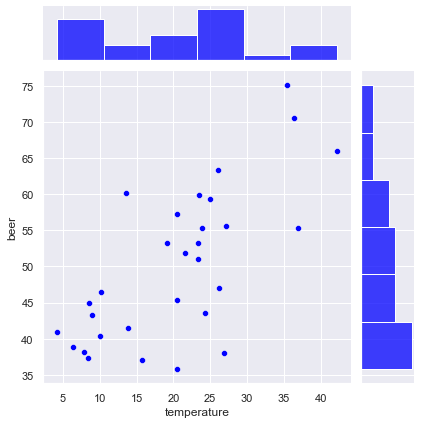

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
# 用于绘图的库
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
# 用于统计模型的库，部分版本会报错
import statsmodels.formula.api as smf
import statsmodels.api as sm
# 设置浮点数打印精度
%precision 3
# 在Jupter Notebook中显示图形
%matplotlib inline
beer = pd.read_csv("./data/5-1-1-beer.csv")
beer.head()
sns.jointplot(x = "temperature", y = "beer",
              data = beer, color = "blue")

## 建模
啤酒销售额 ~ N(β₀ + β₁ X 气温, σ²)
建立一般的正态模型


In [4]:
# 使用statsmodels实现模型化
# 注意这个~符号
in_model = smf.ols(formula = "beer ~ temperature",data = beer).fit()

in_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     28.45
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           1.11e-05
Time:                        15:43:36   Log-Likelihood:                -102.45
No. Observations:                  30   AIC:                             208.9
Df Residuals:                      28   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.6102      3.235     10.699      0.000      27.984      41.237
temperature     0.7654      0.144      5.334      0.000       0.471       1.059
==============================================================================
Omnibus:                        0.587   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.290
Skew:                          -0.240   Prob(JB):                        0.865
Kurtosis:                       2.951   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 使用AIC进行模型选择
ols(最小二乘法)

In [5]:
null_model = smf.ols("beer ~ 1", data = beer).fit()
null_model.aic
in_model.aic

# 含有解释变量的模型的AIC更小
in_model.llf

# 解释变量个数
in_model.df_model

# 最终的AIC计算如下:
-2 * (in_model.llf - (in_model.df_model + 1))



208.90902935575437

### 回归直线
模型预测的响应变脸的图形就是回归直线


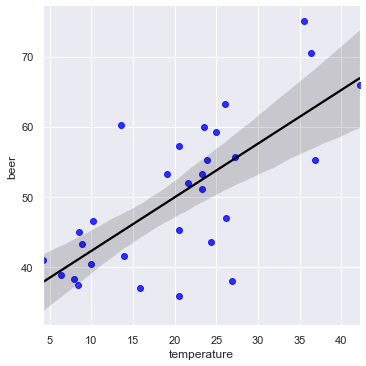

In [6]:
sns.lmplot(x = "temperature", y = "beer", data = beer, scatter_kws = {"color":"blue"},
                line_kws = {"color":"black"})


### 使用模型进行预测


In [7]:
in_model.predict()
in_model.predict(pd.DataFrame({"temperature":[0]}))

# 参数
in_model.params
# 气温20摄氏度的期望
in_model.predict(pd.DataFrame({"temperature":[20]}))

beta0 = in_model.params[0]
beta1 = in_model.params[1]

temperature = 20
beta0 + beta1 + temperature


55.375642843501936

### 获取残差

In [8]:
resid = in_model.resid
print(resid.head(3))

y_hat = beta0 + beta1 * beer["temperature"]
y_hat.head(3)
print((beer.beer - y_hat).head(3))

0   -5.001481
1    5.554095
2   -1.864491
dtype: float64
0   -5.001481
1    5.554095
2   -1.864491
dtype: float64


### 决定系数

In [9]:
mu = np.mean(beer.beer)
y = beer.beer
yhat = in_model.predict()

(np.sum(yhat - mu) ** 2 ) / np.sum((y - mu) ** 2)
# 也可以通过下面语句
in_model.rsquared

# 首先，计算模型可以预测差异与模型不可预测都残差平方和的总和
temp = np.sum((yhat - mu)**2) + sum(resid**2)
temp
np.sum((y - mu)**2)

1 - np.sum(resid**2) / np.sum((y - mu)**2)

0.5039593230611858

### 修正系数

In [10]:
# 通过自由度来考虑决定系数
n = len(beer.beer)
s = 1
1 - ((np.sum(resid**2) / (n - s - 1)) /
     (np.sum((y - mu)**2) / (n - 1)))

# 也可以通过下面的语句
in_model.rsquared_adj

0.48624358459908534

In [ ]:
sns.displot(resid)

sns.jointplot(in_model.fittedvalues, resid,
              joint_kws={"color":"blue"},
              marginal_kws={"color":"black"})

### 分位图
分位图是用来比较理论分位数(theoretical quantiles)与实际分位数(sample quantiles)的散点图，也叫Q~Q图🦝。
Q是Quantile的缩写

C:\Users\Cherry\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


array([-1.849, -1.518, -1.3  , -1.131, -0.989, -0.865, -0.753, -0.649,
       -0.552, -0.46 , -0.372, -0.287, -0.204, -0.122, -0.04 ,  0.04 ,
        0.122,  0.204,  0.287,  0.372,  0.46 ,  0.552,  0.649,  0.753,
        0.865,  0.989,  1.131,  1.3  ,  1.518,  1.849])

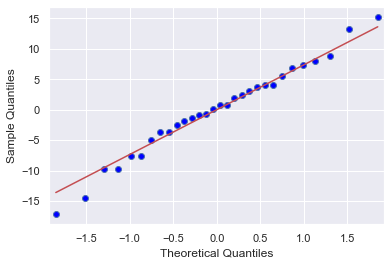

In [12]:
fig = sm.qqplot(resid, line = "s")
resid_sort = resid.sort_values()
resid_sort.head()

# 这里可以看到分位图的
nobs = len(resid_sort)
cdf = np.arange(1, nobs + 1) / (nobs + 1)
cdf
ppf = stats.norm.ppf(cdf)
ppf


## 方差分析
方差分析是来检验均值差的方法

### 多重假设检验
反复检验导致结果更容易出现问题的叫做`多重假设检验`问题

### 方差分析的直观理解:F比
方差分析的英文名(ANalysis Of VAriance)

F比 = 效应的方差 / 误差的方差

### 方差分析的直观理解
一般的方差分析其实通过看图就可以明白一二


   beer weather
0     6  cloudy
1     8  cloudy
2     2   rainy
3     4   rainy
4    10   sunny
5    12   sunny
         beer
weather      
cloudy      7
rainy       3
sunny      11


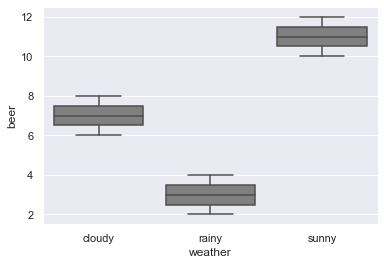

In [13]:
import numpy as np
import pandas as pd
from scipy import stats

# 用于绘图的库
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
# 用于估计统计模型的库（部分版本会报出警告信息）
import statsmodels.formula.api as smf
import statsmodels.api as sm
# 设置浮点数打印精度
%precision 3
# 在Jupyter Notebook中显示图形
%matplotlib inline

# 定义一组数据
weather = [
    "cloudy", "cloudy",
    "rainy", "rainy",
    "sunny", "sunny"
]

beer = [6, 8, 2, 4, 10, 12]

# 转换成数据帧
weather_beer = pd.DataFrame({
    "beer"  : beer,
    "weather": weather
})
print(weather_beer)

# 样本量很小所以绘制箱形图而非小提琴图
sns.boxplot(x = "weather", y = "beer",
            data = weather_beer, color = "gray")

print(weather_beer.groupby("weather").mean())

#### 方差分析：计算组间偏差平方和与组内偏差平方和
分布手动实现单因素方差分析

In [ ]:
# 天气的影响
effect = [7, 7, 3, 3, 11, 11]

# 组间偏差平方和
mu_effect = sp.mean(effect)
squares_model = sp.sum((effect - mu_effect) ** 2)
print(squares_model)

resid = weather_beer.beer - effect
print(resid)

# 组内偏差平方和
squares_resid = sp.sum(resid ** 2)
print(squares_resid)

#### 方差分析：计算组间方差与组内方差
样本方差和无偏方差是有一定的区别的

组间差异的自由度取决于水平数量。
组内差异的自由度取决于样本容量和水平数量。
反正看推导就知道啦

In [15]:
df_model = 2 # 组间差异的自由度
df_resid = 3 # 组内差异的自由度

# 组内方差
variance_model = squares_model / df_model
print(variance_model)

# 组间方差
variance_resid = squares_resid / df_resid
print(variance_resid)

32.0
2.0


#### 方差分析：计算p值


In [16]:
f_ratio = variance_model / variance_resid
print(f_ratio)

# 通过sp.stats.f.cdf函数使用F分布的累计分布函数计算p值
# 参数为F比的值和2个自由度
1 - sp.stats.f.cdf(x = f_ratio, dfn = df_model, dfd = df_resid)


16.0


0.02509457330439091

### 使用statsmodels的方差分析


In [19]:
# 使用正态线性模型，进行单因素方差分析
anova_model = smf.ols("beer ~ weather",
                      data = weather_beer).fit()
print(sm.stats.anova_lm(anova_model, type = 2))

# 打印已估计模型的参数
anova_model.params



           df  sum_sq  mean_sq     F    PR(>F)
weather   2.0    64.0     32.0  16.0  0.025095
Residual  3.0     6.0      2.0   NaN       NaN


Intercept           7.0
weather[T.rainy]   -4.0
weather[T.sunny]    4.0
dtype: float64

### 回归模型中的方差分析

In [27]:
# 正态线性模型中广泛地应用了方差分析。
# 当解释变量为连续变量时，方差分析依然有效

# 读取数据
beer = pd.read_csv("data/5-1-1-beer.csv")
# 估计模型
lm_model = smf.ols(formula = "beer ~ temperature",
                   data = beer).fit()


In [30]:
# 与解释变量为分类变量的模型类似，
# 我们可以用模型的拟合值与残差计算F比
df_lm_model = 1      #模型自由度
df_lm_resid = 28    #残差自由度

# 拟合值
lm_effect = lm_model.fittedvalues
# 残差
lm_resid = lm_model.resid
# 气温的影响大小
mu = sp.mean(lm_effect)
squares_lm_model = sp.sum(lm_effect)
variance_lm_model = squares_lm_model / df_lm_model
# 残差大小
squares_lm_resid = sp.sum((lm_resid) ** 2)
variance_lm_resid = squares_lm_resid / df_lm_resid

# F比
f_value_lm = variance_lm_model / variance_lm_resid
print(f_value_lm)

lm_model.summary()

25.933355187677044


C:\Users\Cherry\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Cherry\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  if sys.path[0] == '':
C:\Users\Cherry\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  from ipykernel import kernelapp as app


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     28.45
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           1.11e-05
Time:                        16:36:40   Log-Likelihood:                -102.45
No. Observations:                  30   AIC:                             208.9
Df Residuals:                      28   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.6102      3.235     10.699      0.000      27.984      41.237
temperature     0.7654      0.144      5.334      0.000       0.471       1.059
==============================================================================
Omnibus:                        0.587   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.290
Skew:                          -0.240   Prob(JB):                        0.865
Kurtosis:                       2.951   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""